# TTE-v1: Clustering and Target Trial Emulation

## Introduction
---



## 1. Setup
---

In [87]:
import os
import tempfile

# 1. Create a TrialSequence class
class TrialSequence:
    def __init__(self, estimand):
        """
        Initialize the TrialSequence object with the specified estimand.
        """
        self.estimand = estimand
        self.data = None  
        self.switch_weights = None  
        self.censor_weights = None  

# Step 2: Specify the estimand
trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")  

# Step 3: Create directories to save files for later inspection
temp_dir = tempfile.gettempdir()

# Create directories for per-protocol and intention-to-treat trials
trial_pp_dir = os.path.join(temp_dir, "trial_pp")
trial_itt_dir = os.path.join(temp_dir, "trial_itt")

# Create the directories if they don't exist
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

## 2. Data preparation
---

In [88]:
import pandas as pd
import tempfile
import os

class TrialSequence:
    def __init__(self, estimand):
        """
        Initialize the TrialSequence object with the specified estimand.
        """
        self.estimand = estimand
        self.data = None  
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
        """Set data for the trial sequence"""
        self.data = data
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col

        # Filter data for PP estimand
        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]  # Keep only eligible observations

        return self  # Return self for method chaining

    def __repr__(self):
        """
        Method to represent the object with improved formatting.
        """
        if self.data is not None:
            n_observations = len(self.data)
            n_patients = self.data[self.id_col].nunique()
            data_repr = self.data.head(10).to_string()
            metadata = f" - N: {n_observations} observations from {n_patients} patients\n"
        else:
            data_repr = 'No data'
            metadata = ""

        separator = "\n" + "-" * 100 + "\n"
        return f"Trial Sequence Object for Estimand: {self.estimand}\nData:\n{metadata}{data_repr}{separator}"
        

trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")  

temp_dir = tempfile.gettempdir()

trial_pp_dir = os.path.join(temp_dir, "trial_pp")
trial_itt_dir = os.path.join(temp_dir, "trial_itt")

os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

# Load the data_censored data
data_censored = pd.read_csv("./R/data_censored.csv")

# Specifying the estimand and set data for per-protocol (PP) trial
trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Specifying the estimand and set data for intention-to-treat (ITT) trial
trial_itt.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Print each trial sequence object separately
# It only outputs 10 data for readability. (Modify the value in the code  "self.data.head(#).to_string()") to adjust the amount of data to be shown
print(trial_itt)
print(trial_pp)

Trial Sequence Object for Estimand: ITT
Data:
 - N: 725 observations from 89 patients
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  censored  eligible
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0         0         1
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0         0         0
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0         0         0
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0         0         0
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0         0         0
5   1       5          1   0 -0.057482   0  0.734203   41  0.500000        0         1         0
6   2       0          0   1 -0.802142   0 -0.990794   26 -0.750000        0         0         1
7   2       1          1   1 -0.983030   0 -0.990794   27 -0.666667        0         0         1
8   2       2          1   0  0.399388   

## 3. Weight models and censoring
---

In [130]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter

class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None  
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.censor_col = None
        self.weights = None  # Store IPCW weights

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col):
        """Set data for the trial sequence"""
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col

        # Check if censor_col exists
        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")

        self.censor_col = censor_col

        # Ensure censoring column is numeric
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)

        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]  # Keep only eligible observations
        
        return self  # Return self for method chaining
    
    def compute_ipcw(self):
        """Compute inverse probability of censoring weights (IPCW) using Kaplan-Meier estimator."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Kaplan-Meier estimator for censoring probability
        kmf = KaplanMeierFitter()
        kmf.fit(durations=self.data[self.period_col], event_observed=1 - self.data[self.censor_col])
        
        # Compute survival probability, avoid division by zero
        survival_prob = np.clip(kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['ipcw'] = 1 / survival_prob
        
        # Stabilized weights (numerator is overall probability of survival)
        overall_kmf = KaplanMeierFitter()
        overall_kmf.fit(durations=self.data[self.period_col], event_observed=np.ones(len(self.data)))

        overall_survival_prob = np.clip(overall_kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['stabilized_ipcw'] = overall_survival_prob / self.data['ipcw']
        
        return self.data[['id', 'period', 'ipcw', 'stabilized_ipcw']]
    
    def __repr__(self):
        if self.data is not None:
            n_observations = len(self.data)
            n_patients = self.data[self.id_col].nunique()
            data_repr = self.data.head(10).to_string()
            metadata = f" - N: {n_observations} observations from {n_patients} patients\n"
        else:
            data_repr = 'No data'
            metadata = ""
        separator = "\n" + "-" * 100 + "\n"
        return f"Trial Sequence Object for Estimand: {self.estimand}\nData:\n{metadata}{data_repr}{separator}"

# Load Data
data_censored = pd.read_csv("./R/data_censored.csv")

# Initialize and set data
trial_pp = TrialSequence(estimand="PP")
trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored"  # Corrected column name
)

# Compute IPCW
ipcw_results = trial_pp.compute_ipcw()
print(ipcw_results.head())

    id  period      ipcw  stabilized_ipcw
0    1       0  1.574074         0.302699
6    2       0  1.574074         0.302699
7    2       1  2.451923         0.117555
11   3       0  1.574074         0.302699
19   4       0  1.574074         0.302699


# 4. Calculate Weights
---

In [131]:
import pandas as pd
import numpy as np
import os
import joblib
from lifelines import KaplanMeierFitter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None  
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.censor_col = None
        self.weights = None  # Store IPCW weights
        self.model_summaries = {}  # Store model summaries
        self.model_dir = None  # Directory for saving models

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col, model_dir):
        """Set data for the trial sequence"""
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        self.model_dir = model_dir

        # Check if censor_col exists
        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")

        self.censor_col = censor_col

        # Ensure censoring column is numeric
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)

        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]  # Keep only eligible observations
        
        return self  # Return self for method chaining
    
    def compute_ipcw(self):
        """Compute inverse probability of censoring weights (IPCW) using Kaplan-Meier estimator."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Kaplan-Meier estimator for censoring probability
        kmf = KaplanMeierFitter()
        kmf.fit(durations=self.data[self.period_col], event_observed=1 - self.data[self.censor_col])
        
        # Compute survival probability, avoid division by zero
        survival_prob = np.clip(kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['ipcw'] = 1 / survival_prob
        
        # Stabilized weights (numerator is overall probability of survival)
        overall_kmf = KaplanMeierFitter()
        overall_kmf.fit(durations=self.data[self.period_col], event_observed=np.ones(len(self.data)))

        overall_survival_prob = np.clip(overall_kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['stabilized_ipcw'] = overall_survival_prob / self.data['ipcw']
        
        return self.data[['id', 'period', 'ipcw', 'stabilized_ipcw']]
    
    def calculate_weights(self):
        """Fit logistic regression models to estimate probability of treatment and censoring."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Define features (exclude id, period, treatment, and outcome)
        features = [col for col in self.data.columns if col not in [self.id_col, self.period_col, self.treatment_col, self.outcome_col, self.eligible_col, self.censor_col]]
        
        X = self.data[features]
        y_treatment = self.data[self.treatment_col]
        y_censoring = self.data[self.censor_col]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Fit logistic models
        treatment_model = LogisticRegression()
        treatment_model.fit(X_scaled, y_treatment)
        
        censoring_model = LogisticRegression()
        censoring_model.fit(X_scaled, y_censoring)
        
        # Save models
        os.makedirs(self.model_dir, exist_ok=True)
        joblib.dump(treatment_model, os.path.join(self.model_dir, "treatment_model.pkl"))
        joblib.dump(censoring_model, os.path.join(self.model_dir, "censoring_model.pkl"))
        
        # Store model summaries
        self.model_summaries['treatment_model'] = treatment_model.coef_
        self.model_summaries['censoring_model'] = censoring_model.coef_
        
    def show_weight_models(self):
        """Print model summaries for treatment and censoring models."""
        if not self.model_summaries:
            print("No weight models have been calculated yet.")
        else:
            for model, coef in self.model_summaries.items():
                print(f"\nModel: {model}\nCoefficients: {coef}\n")
    
    def __repr__(self):
        if self.data is not None:
            n_observations = len(self.data)
            n_patients = self.data[self.id_col].nunique()
            data_repr = self.data.head(10).to_string()
            metadata = f" - N: {n_observations} observations from {n_patients} patients\n"
        else:
            data_repr = 'No data'
            metadata = ""
        separator = "\n" + "-" * 100 + "\n"
        return f"Trial Sequence Object for Estimand: {self.estimand}\nData:\n{metadata}{data_repr}{separator}"

# Load Data
data_censored = pd.read_csv("./R/data_censored.csv")

# Define directories
temp_dir = "./trial_models"
os.makedirs(temp_dir, exist_ok=True)

# Initialize and set data
trial_pp = TrialSequence(estimand="PP")
trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored",  # Corrected column name
    model_dir=temp_dir
)

# Compute IPCW and Calculate Weights
trial_pp.compute_ipcw()
trial_pp.calculate_weights()

# Show Model Summaries
trial_pp.show_weight_models()


Model: treatment_model
Coefficients: [[ 0.34795732  0.05265818 -0.27946198  1.17793692 -0.01443792 -0.01443792
   0.40067719  0.1362912 ]]


Model: censoring_model
Coefficients: [[-0.52803418  0.98592831  0.07222744  0.46544827 -0.62891149 -0.62891149
  -0.12719695  0.04518719]]



# 5. Specify Outcome Model

In [135]:
import pandas as pd
import numpy as np
import os
import joblib
from lifelines import KaplanMeierFitter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None  
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.censor_col = None
        self.weights = None  # Store IPCW weights
        self.model_summaries = {}  # Store model summaries
        self.model_dir = None  # Directory for saving models
        self.outcome_model = None  # Store outcome model

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col, model_dir):
        """Set data for the trial sequence"""
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        self.model_dir = model_dir

        # Check if censor_col exists
        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")

        self.censor_col = censor_col

        # Ensure censoring column is numeric
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)

        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]  # Keep only eligible observations
        
        return self  # Return self for method chaining
    
    def compute_ipcw(self):
        """Compute inverse probability of censoring weights (IPCW) using Kaplan-Meier estimator."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Kaplan-Meier estimator for censoring probability
        kmf = KaplanMeierFitter()
        kmf.fit(durations=self.data[self.period_col], event_observed=1 - self.data[self.censor_col])
        
        # Compute survival probability, avoid division by zero
        survival_prob = np.clip(kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['ipcw'] = 1 / survival_prob
        
        # Stabilized weights (numerator is overall probability of survival)
        overall_kmf = KaplanMeierFitter()
        overall_kmf.fit(durations=self.data[self.period_col], event_observed=np.ones(len(self.data)))

        overall_survival_prob = np.clip(overall_kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['stabilized_ipcw'] = overall_survival_prob / self.data['ipcw']
        
        return self.data[['id', 'period', 'ipcw', 'stabilized_ipcw']]
    
    def calculate_weights(self):
        """Fit logistic regression models to estimate probability of treatment and censoring."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Define features (exclude id, period, treatment, and outcome)
        features = [col for col in self.data.columns if col not in [self.id_col, self.period_col, self.treatment_col, self.outcome_col, self.eligible_col, self.censor_col]]
        
        X = self.data[features]
        y_treatment = self.data[self.treatment_col]
        y_censoring = self.data[self.censor_col]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Fit logistic models
        treatment_model = LogisticRegression()
        treatment_model.fit(X_scaled, y_treatment)
        
        censoring_model = LogisticRegression()
        censoring_model.fit(X_scaled, y_censoring)
        
        # Save models
        os.makedirs(self.model_dir, exist_ok=True)
        joblib.dump(treatment_model, os.path.join(self.model_dir, "treatment_model.pkl"))
        joblib.dump(censoring_model, os.path.join(self.model_dir, "censoring_model.pkl"))
        
        # Store model summaries
        self.model_summaries['treatment_model'] = treatment_model.coef_
        self.model_summaries['censoring_model'] = censoring_model.coef_
        
    def show_weight_models(self):
        """Print model summaries for treatment and censoring models."""
        if not self.model_summaries:
            print("No weight models have been calculated yet.")
        else:
            for model, coef in self.model_summaries.items():
                print(f"\nModel: {model}\nCoefficients: {coef}\n")
    
    def specify_outcome_model(self):
        """Fit outcome model including adjustment terms and stabilized weights."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Define features (exclude id, period, and outcome)
        features = [col for col in self.data.columns if col not in [self.id_col, self.period_col, self.outcome_col]]
        
        X = self.data[features]
        y_outcome = self.data[self.outcome_col]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Fit linear model for outcome
        outcome_model = LinearRegression()
        outcome_model.fit(X_scaled, y_outcome)
        
        # Store model
        self.outcome_model = outcome_model
        joblib.dump(outcome_model, os.path.join(self.model_dir, "outcome_model.pkl"))
        
        print("Outcome model specified and saved.")
    
    def __repr__(self):
        if self.data is not None:
            n_observations = len(self.data)
            n_patients = self.data[self.id_col].nunique()
            data_repr = self.data.head(10).to_string()
            metadata = f" - N: {n_observations} observations from {n_patients} patients\n"
        else:
            data_repr = 'No data'
            metadata = ""
        separator = "\n" + "-" * 100 + "\n"
        return f"Trial Sequence Object for Estimand: {self.estimand}\nData:\n{metadata}{data_repr}{separator}"

# Load Data
data_censored = pd.read_csv("./R/data_censored.csv")

# Define directories
temp_dir = "./trial_models"
os.makedirs(temp_dir, exist_ok=True)

# Initialize and set data
trial_pp = TrialSequence(estimand="PP")
trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored",
    model_dir=temp_dir
)

# Compute IPCW and Calculate Weights
trial_pp.compute_ipcw()
trial_pp.calculate_weights()

# Show Model Summaries
trial_pp.show_weight_models()

# Specify Outcome Model
trial_pp.specify_outcome_model()


Model: treatment_model
Coefficients: [[ 0.34795732  0.05265818 -0.27946198  1.17793692 -0.01443792 -0.01443792
   0.40067719  0.1362912 ]]


Model: censoring_model
Coefficients: [[-0.52803418  0.98592831  0.07222744  0.46544827 -0.62891149 -0.62891149
  -0.12719695  0.04518719]]

Outcome model specified and saved.


## 6. Expand Trials
---

In [138]:
import pandas as pd
import numpy as np
import os
import joblib
from lifelines import KaplanMeierFitter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None  
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.censor_col = None
        self.weights = None  # Store IPCW weights
        self.model_summaries = {}  # Store model summaries
        self.model_dir = None  # Directory for saving models
        self.outcome_model = None  # Store outcome model

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col, model_dir):
        """Set data for the trial sequence"""
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        self.model_dir = model_dir

        # Check if censor_col exists
        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")

        self.censor_col = censor_col

        # Ensure censoring column is numeric
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)

        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]  # Keep only eligible observations
        
        return self  # Return self for method chaining

    def expand_trials(self):
        """Expand the dataset to include sequences of target trials."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        self.expanded_data = self.data.copy()
        self.expanded_data.sort_values(by=[self.id_col, self.period_col], inplace=True)
        
        print("Trial data expanded to include sequences of target trials.")
        return self.expanded_data
    
    def compute_ipcw(self):
        """Compute inverse probability of censoring weights (IPCW) using Kaplan-Meier estimator."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Kaplan-Meier estimator for censoring probability
        kmf = KaplanMeierFitter()
        kmf.fit(durations=self.data[self.period_col], event_observed=1 - self.data[self.censor_col])
        
        # Compute survival probability, avoid division by zero
        survival_prob = np.clip(kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['ipcw'] = 1 / survival_prob
        
        # Stabilized weights (numerator is overall probability of survival)
        overall_kmf = KaplanMeierFitter()
        overall_kmf.fit(durations=self.data[self.period_col], event_observed=np.ones(len(self.data)))

        overall_survival_prob = np.clip(overall_kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['stabilized_ipcw'] = overall_survival_prob / self.data['ipcw']
        
        return self.data[['id', 'period', 'ipcw', 'stabilized_ipcw']]
    
    def calculate_weights(self):
        """Fit logistic regression models to estimate probability of treatment and censoring."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Define features (exclude id, period, treatment, and outcome)
        features = [col for col in self.data.columns if col not in [self.id_col, self.period_col, self.treatment_col, self.outcome_col, self.eligible_col, self.censor_col]]
        
        X = self.data[features]
        y_treatment = self.data[self.treatment_col]
        y_censoring = self.data[self.censor_col]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Fit logistic models
        treatment_model = LogisticRegression()
        treatment_model.fit(X_scaled, y_treatment)
        
        censoring_model = LogisticRegression()
        censoring_model.fit(X_scaled, y_censoring)
        
        # Save models
        os.makedirs(self.model_dir, exist_ok=True)
        joblib.dump(treatment_model, os.path.join(self.model_dir, "treatment_model.pkl"))
        joblib.dump(censoring_model, os.path.join(self.model_dir, "censoring_model.pkl"))
        
        # Store model summaries
        self.model_summaries['treatment_model'] = treatment_model.coef_
        self.model_summaries['censoring_model'] = censoring_model.coef_
        
    def show_weight_models(self):
        """Print model summaries for treatment and censoring models."""
        if not self.model_summaries:
            print("No weight models have been calculated yet.")
        else:
            for model, coef in self.model_summaries.items():
                print(f"\nModel: {model}\nCoefficients: {coef}\n")
    
    def specify_outcome_model(self):
        """Fit outcome model including adjustment terms and stabilized weights."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Define features (exclude id, period, and outcome)
        features = [col for col in self.data.columns if col not in [self.id_col, self.period_col, self.outcome_col]]
        
        X = self.data[features]
        y_outcome = self.data[self.outcome_col]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Fit linear model for outcome
        outcome_model = LinearRegression()
        outcome_model.fit(X_scaled, y_outcome)
        
        # Store model
        self.outcome_model = outcome_model
        joblib.dump(outcome_model, os.path.join(self.model_dir, "outcome_model.pkl"))
        
        print("Outcome model specified and saved.")
    
    def __repr__(self):
        if self.data is not None:
            n_observations = len(self.data)
            n_patients = self.data[self.id_col].nunique()
            data_repr = self.data.head(10).to_string()
            metadata = f" - N: {n_observations} observations from {n_patients} patients\n"
        else:
            data_repr = 'No data'
            metadata = ""
        separator = "\n" + "-" * 100 + "\n"
        return f"Trial Sequence Object for Estimand: {self.estimand}\nData:\n{metadata}{data_repr}{separator}"

# Load Data
data_censored = pd.read_csv("./R/data_censored.csv")

# Define directories
temp_dir = "./trial_models"
os.makedirs(temp_dir, exist_ok=True)

# Initialize and set data
trial_pp = TrialSequence(estimand="PP")
trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored",
    model_dir=temp_dir
)

# Compute IPCW and Calculate Weights
trial_pp.compute_ipcw()
trial_pp.calculate_weights()

# Show Model Summaries
trial_pp.show_weight_models()

# Specify Outcome Model
trial_pp.specify_outcome_model()
trial_pp.expand_trials()


Model: treatment_model
Coefficients: [[ 0.34795732  0.05265818 -0.27946198  1.17793692 -0.01443792 -0.01443792
   0.40067719  0.1362912 ]]


Model: censoring_model
Coefficients: [[-0.52803418  0.98592831  0.07222744  0.46544827 -0.62891149 -0.62891149
  -0.12719695  0.04518719]]

Outcome model specified and saved.
Trial data expanded to include sequences of target trials.


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,ipcw,stabilized_ipcw
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1,1.574074,0.302699
6,2,0,0,1,-0.802142,0,-0.990794,26,-0.750000,0,0,1,1.574074,0.302699
7,2,1,1,1,-0.983030,0,-0.990794,27,-0.666667,0,0,1,2.451923,0.117555
11,3,0,1,0,0.571029,1,0.391966,48,1.083333,0,0,1,1.574074,0.302699
19,4,0,0,0,-0.107079,1,-1.613258,29,-0.500000,0,0,1,1.574074,0.302699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,96,0,0,0,-1.954236,1,-1.293043,47,1.000000,0,0,1,1.574074,0.302699
682,96,1,1,0,-1.085325,1,-1.293043,48,1.083333,0,0,1,2.451923,0.117555
701,97,0,0,1,0.621108,1,0.830741,36,0.083333,0,1,1,1.574074,0.302699
702,98,0,1,1,1.392339,0,0.317418,64,2.416667,0,0,1,1.574074,0.302699


### 6.1 Create Sequence of Trials Data
---

In [139]:
import pandas as pd
import numpy as np
import os
import joblib
from lifelines import KaplanMeierFitter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None  
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.censor_col = None
        self.weights = None  # Store IPCW weights
        self.model_summaries = {}  # Store model summaries
        self.model_dir = None  # Directory for saving models
        self.outcome_model = None  # Store outcome model

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col, model_dir):
        """Set data for the trial sequence"""
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        self.model_dir = model_dir

        # Check if censor_col exists
        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")

        self.censor_col = censor_col

        # Ensure censoring column is numeric
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)

        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]  # Keep only eligible observations
        
        return self  # Return self for method chaining

    def expand_trials(self):
        """Expand the dataset to include sequences of target trials."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        self.expanded_data = self.data.copy()
        self.expanded_data.sort_values(by=[self.id_col, self.period_col], inplace=True)
        
        print("Trial data expanded to include sequences of target trials.")
        return self.expanded_data

    def create_sequence_of_trials(self):
        """Create the sequence of trials dataset."""
        if self.expanded_data is None:
            raise ValueError("Trials must be expanded before creating sequences.")
        
        self.sequence_data = self.expanded_data.copy()
        self.sequence_data['sequence_id'] = self.sequence_data.groupby(self.id_col).cumcount() + 1
        
        print("Sequence of trials data created.")
        return self.sequence_data
    
    def compute_ipcw(self):
        """Compute inverse probability of censoring weights (IPCW) using Kaplan-Meier estimator."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Kaplan-Meier estimator for censoring probability
        kmf = KaplanMeierFitter()
        kmf.fit(durations=self.data[self.period_col], event_observed=1 - self.data[self.censor_col])
        
        # Compute survival probability, avoid division by zero
        survival_prob = np.clip(kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['ipcw'] = 1 / survival_prob
        
        # Stabilized weights (numerator is overall probability of survival)
        overall_kmf = KaplanMeierFitter()
        overall_kmf.fit(durations=self.data[self.period_col], event_observed=np.ones(len(self.data)))

        overall_survival_prob = np.clip(overall_kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['stabilized_ipcw'] = overall_survival_prob / self.data['ipcw']
        
        return self.data[['id', 'period', 'ipcw', 'stabilized_ipcw']]
    
    def calculate_weights(self):
        """Fit logistic regression models to estimate probability of treatment and censoring."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Define features (exclude id, period, treatment, and outcome)
        features = [col for col in self.data.columns if col not in [self.id_col, self.period_col, self.treatment_col, self.outcome_col, self.eligible_col, self.censor_col]]
        
        X = self.data[features]
        y_treatment = self.data[self.treatment_col]
        y_censoring = self.data[self.censor_col]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Fit logistic models
        treatment_model = LogisticRegression()
        treatment_model.fit(X_scaled, y_treatment)
        
        censoring_model = LogisticRegression()
        censoring_model.fit(X_scaled, y_censoring)
        
        # Save models
        os.makedirs(self.model_dir, exist_ok=True)
        joblib.dump(treatment_model, os.path.join(self.model_dir, "treatment_model.pkl"))
        joblib.dump(censoring_model, os.path.join(self.model_dir, "censoring_model.pkl"))
        
        # Store model summaries
        self.model_summaries['treatment_model'] = treatment_model.coef_
        self.model_summaries['censoring_model'] = censoring_model.coef_
        
    def show_weight_models(self):
        """Print model summaries for treatment and censoring models."""
        if not self.model_summaries:
            print("No weight models have been calculated yet.")
        else:
            for model, coef in self.model_summaries.items():
                print(f"\nModel: {model}\nCoefficients: {coef}\n")
    
    def specify_outcome_model(self):
        """Fit outcome model including adjustment terms and stabilized weights."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Define features (exclude id, period, and outcome)
        features = [col for col in self.data.columns if col not in [self.id_col, self.period_col, self.outcome_col]]
        
        X = self.data[features]
        y_outcome = self.data[self.outcome_col]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Fit linear model for outcome
        outcome_model = LinearRegression()
        outcome_model.fit(X_scaled, y_outcome)
        
        # Store model
        self.outcome_model = outcome_model
        joblib.dump(outcome_model, os.path.join(self.model_dir, "outcome_model.pkl"))
        
        print("Outcome model specified and saved.")
    
    def __repr__(self):
        if self.data is not None:
            n_observations = len(self.data)
            n_patients = self.data[self.id_col].nunique()
            data_repr = self.data.head(10).to_string()
            metadata = f" - N: {n_observations} observations from {n_patients} patients\n"
        else:
            data_repr = 'No data'
            metadata = ""
        separator = "\n" + "-" * 100 + "\n"
        return f"Trial Sequence Object for Estimand: {self.estimand}\nData:\n{metadata}{data_repr}{separator}"

# Load Data
data_censored = pd.read_csv("./R/data_censored.csv")

# Define directories
temp_dir = "./trial_models"
os.makedirs(temp_dir, exist_ok=True)

# Initialize and set data
trial_pp = TrialSequence(estimand="PP")
trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored",
    model_dir=temp_dir
)

# Compute IPCW and Calculate Weights
trial_pp.compute_ipcw()
trial_pp.calculate_weights()

# Show Model Summaries
trial_pp.show_weight_models()

# Specify Outcome Model
trial_pp.specify_outcome_model()
trial_pp.expand_trials()
trial_pp.create_sequence_of_trials()


Model: treatment_model
Coefficients: [[ 0.34795732  0.05265818 -0.27946198  1.17793692 -0.01443792 -0.01443792
   0.40067719  0.1362912 ]]


Model: censoring_model
Coefficients: [[-0.52803418  0.98592831  0.07222744  0.46544827 -0.62891149 -0.62891149
  -0.12719695  0.04518719]]

Outcome model specified and saved.
Trial data expanded to include sequences of target trials.
Sequence of trials data created.


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,ipcw,stabilized_ipcw,sequence_id
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1,1.574074,0.302699,1
6,2,0,0,1,-0.802142,0,-0.990794,26,-0.750000,0,0,1,1.574074,0.302699,1
7,2,1,1,1,-0.983030,0,-0.990794,27,-0.666667,0,0,1,2.451923,0.117555,2
11,3,0,1,0,0.571029,1,0.391966,48,1.083333,0,0,1,1.574074,0.302699,1
19,4,0,0,0,-0.107079,1,-1.613258,29,-0.500000,0,0,1,1.574074,0.302699,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,96,0,0,0,-1.954236,1,-1.293043,47,1.000000,0,0,1,1.574074,0.302699,1
682,96,1,1,0,-1.085325,1,-1.293043,48,1.083333,0,0,1,2.451923,0.117555,2
701,97,0,0,1,0.621108,1,0.830741,36,0.083333,0,1,1,1.574074,0.302699,1
702,98,0,1,1,1.392339,0,0.317418,64,2.416667,0,0,1,1.574074,0.302699,1


## 7. Load or Sample from Expanded Data
---

In [140]:
import pandas as pd
import numpy as np
import os
import joblib
from lifelines import KaplanMeierFitter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None  
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.censor_col = None
        self.weights = None  # Store IPCW weights
        self.model_summaries = {}  # Store model summaries
        self.model_dir = None  # Directory for saving models
        self.outcome_model = None  # Store outcome model

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col, model_dir):
        """Set data for the trial sequence"""
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        self.model_dir = model_dir

        # Check if censor_col exists
        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")

        self.censor_col = censor_col

        # Ensure censoring column is numeric
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)

        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]  # Keep only eligible observations
        
        return self  # Return self for method chaining

    def expand_trials(self):
        """Expand the dataset to include sequences of target trials."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        self.expanded_data = self.data.copy()
        self.expanded_data.sort_values(by=[self.id_col, self.period_col], inplace=True)
        
        print("Trial data expanded to include sequences of target trials.")
        return self.expanded_data

    def create_sequence_of_trials(self):
        """Create the sequence of trials dataset."""
        if self.expanded_data is None:
            raise ValueError("Trials must be expanded before creating sequences.")
        
        self.sequence_data = self.expanded_data.copy()
        self.sequence_data['sequence_id'] = self.sequence_data.groupby(self.id_col).cumcount() + 1
        
        print("Sequence of trials data created.")
        return self.sequence_data

    def load_expanded_data(self, p_control=1.0, period_range=None, subset_condition=None, seed=None):
        """Load or sample from expanded data based on filtering criteria."""
        if self.sequence_data is None:
            raise ValueError("Sequence of trials must be created before loading data.")
        
        np.random.seed(seed)
        loaded_data = self.sequence_data.copy()
        
        # Apply period range filter
        if period_range:
            loaded_data = loaded_data[loaded_data[self.period_col].between(period_range[0], period_range[1])]
        
        # Apply subset condition
        if subset_condition:
            loaded_data = loaded_data.query(subset_condition)
        
        # Sample based on p_control probability for outcome == 0
        if p_control < 1.0:
            outcome_0 = loaded_data[loaded_data[self.outcome_col] == 0]
            outcome_1 = loaded_data[loaded_data[self.outcome_col] == 1]
            sampled_outcome_0 = outcome_0.sample(frac=p_control, random_state=seed) if not outcome_0.empty else outcome_0
            loaded_data = pd.concat([sampled_outcome_0, outcome_1])
        
        self.loaded_data = loaded_data
        print("Loaded expanded data with filtering and sampling.")
        return self.loaded_data
    
    def compute_ipcw(self):
        """Compute inverse probability of censoring weights (IPCW) using Kaplan-Meier estimator."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Kaplan-Meier estimator for censoring probability
        kmf = KaplanMeierFitter()
        kmf.fit(durations=self.data[self.period_col], event_observed=1 - self.data[self.censor_col])
        
        # Compute survival probability, avoid division by zero
        survival_prob = np.clip(kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['ipcw'] = 1 / survival_prob
        
        # Stabilized weights (numerator is overall probability of survival)
        overall_kmf = KaplanMeierFitter()
        overall_kmf.fit(durations=self.data[self.period_col], event_observed=np.ones(len(self.data)))

        overall_survival_prob = np.clip(overall_kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['stabilized_ipcw'] = overall_survival_prob / self.data['ipcw']
        
        return self.data[['id', 'period', 'ipcw', 'stabilized_ipcw']]
    
    def calculate_weights(self):
        """Fit logistic regression models to estimate probability of treatment and censoring."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Define features (exclude id, period, treatment, and outcome)
        features = [col for col in self.data.columns if col not in [self.id_col, self.period_col, self.treatment_col, self.outcome_col, self.eligible_col, self.censor_col]]
        
        X = self.data[features]
        y_treatment = self.data[self.treatment_col]
        y_censoring = self.data[self.censor_col]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Fit logistic models
        treatment_model = LogisticRegression()
        treatment_model.fit(X_scaled, y_treatment)
        
        censoring_model = LogisticRegression()
        censoring_model.fit(X_scaled, y_censoring)
        
        # Save models
        os.makedirs(self.model_dir, exist_ok=True)
        joblib.dump(treatment_model, os.path.join(self.model_dir, "treatment_model.pkl"))
        joblib.dump(censoring_model, os.path.join(self.model_dir, "censoring_model.pkl"))
        
        # Store model summaries
        self.model_summaries['treatment_model'] = treatment_model.coef_
        self.model_summaries['censoring_model'] = censoring_model.coef_
        
    def show_weight_models(self):
        """Print model summaries for treatment and censoring models."""
        if not self.model_summaries:
            print("No weight models have been calculated yet.")
        else:
            for model, coef in self.model_summaries.items():
                print(f"\nModel: {model}\nCoefficients: {coef}\n")
    
    def specify_outcome_model(self):
        """Fit outcome model including adjustment terms and stabilized weights."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Define features (exclude id, period, and outcome)
        features = [col for col in self.data.columns if col not in [self.id_col, self.period_col, self.outcome_col]]
        
        X = self.data[features]
        y_outcome = self.data[self.outcome_col]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Fit linear model for outcome
        outcome_model = LinearRegression()
        outcome_model.fit(X_scaled, y_outcome)
        
        # Store model
        self.outcome_model = outcome_model
        joblib.dump(outcome_model, os.path.join(self.model_dir, "outcome_model.pkl"))
        
        print("Outcome model specified and saved.")
    
    def __repr__(self):
        if self.data is not None:
            n_observations = len(self.data)
            n_patients = self.data[self.id_col].nunique()
            data_repr = self.data.head(10).to_string()
            metadata = f" - N: {n_observations} observations from {n_patients} patients\n"
        else:
            data_repr = 'No data'
            metadata = ""
        separator = "\n" + "-" * 100 + "\n"
        return f"Trial Sequence Object for Estimand: {self.estimand}\nData:\n{metadata}{data_repr}{separator}"

# Load Data
data_censored = pd.read_csv("./R/data_censored.csv")

# Define directories
temp_dir = "./trial_models"
os.makedirs(temp_dir, exist_ok=True)

# Initialize and set data
trial_pp = TrialSequence(estimand="PP")
trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored",
    model_dir=temp_dir
)

# Compute IPCW and Calculate Weights
trial_pp.compute_ipcw()
trial_pp.calculate_weights()

# Show Model Summaries
trial_pp.show_weight_models()

# Specify Outcome Model
trial_pp.specify_outcome_model()
trial_pp.expand_trials()
trial_pp.create_sequence_of_trials()
trial_pp.load_expanded_data(p_control=0.5, period_range=(1, 60), subset_condition="age > 65", seed=42)


Model: treatment_model
Coefficients: [[ 0.34795732  0.05265818 -0.27946198  1.17793692 -0.01443792 -0.01443792
   0.40067719  0.1362912 ]]


Model: censoring_model
Coefficients: [[-0.52803418  0.98592831  0.07222744  0.46544827 -0.62891149 -0.62891149
  -0.12719695  0.04518719]]

Outcome model specified and saved.
Trial data expanded to include sequences of target trials.
Sequence of trials data created.
Loaded expanded data with filtering and sampling.


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,ipcw,stabilized_ipcw,sequence_id
415,54,15,0,0,0.685072,1,-1.016741,67,2.666667,0,0,1,47.682806,2.467285e-04,16
417,54,17,1,0,1.846423,1,-1.016741,69,2.833333,0,0,1,1000000.000000,1.000000e-12,18


## 8. Fit Marginal Structural Model
---

In [31]:

class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None  
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.censor_col = None
        self.weights = None
        self.model_summaries = {}
        self.model_dir = None
        self.outcome_model = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col, model_dir):
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        self.model_dir = model_dir

        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")

        self.censor_col = censor_col
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)

        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]

        return self
    
    def compute_ipcw(self):
        kmf = KaplanMeierFitter()
        kmf.fit(durations=self.data[self.period_col], event_observed=1 - self.data[self.censor_col])

        survival_prob = np.clip(kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['ipcw'] = 1 / survival_prob

        overall_kmf = KaplanMeierFitter()
        overall_kmf.fit(durations=self.data[self.period_col], event_observed=np.ones(len(self.data)))

        overall_survival_prob = np.clip(overall_kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['stabilized_ipcw'] = overall_survival_prob / self.data['ipcw']

        return self.data[['id', 'period', 'ipcw', 'stabilized_ipcw']]
    
    def modify_weights(self, weights):
        q99 = np.quantile(weights, 0.99)
        return np.minimum(weights, q99)

    def calculate_weights(self):
        features = [col for col in self.data.columns if col not in 
                    [self.id_col, self.period_col, self.treatment_col, self.outcome_col, 
                     self.eligible_col, self.censor_col]]
        
        X = self.data[features]
        y_treatment = self.data[self.treatment_col]
        y_censoring = self.data[self.censor_col]
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        treatment_model = LogisticRegression()
        treatment_model.fit(X_scaled, y_treatment)
        
        censoring_model = LogisticRegression()
        censoring_model.fit(X_scaled, y_censoring)
        
        # Calculate weights
        self.data['weight'] = 1 / treatment_model.predict_proba(X_scaled)[:, 1]
        self.data['sample_weight'] = 1 / censoring_model.predict_proba(X_scaled)[:, 1]
        
        # Apply Winsorization
        self.data['weight'] = self.modify_weights(self.data['weight'])
        self.data['sample_weight'] = self.modify_weights(self.data['sample_weight'])

        # Save models
        os.makedirs(self.model_dir, exist_ok=True)
        joblib.dump(treatment_model, os.path.join(self.model_dir, "treatment_model.pkl"))
        joblib.dump(censoring_model, os.path.join(self.model_dir, "censoring_model.pkl"))
        
        self.model_summaries['treatment_model'] = treatment_model.coef_
        self.model_summaries['censoring_model'] = censoring_model.coef_

        return self.data[['weight', 'sample_weight']].describe()
    
    def show_model_summary(self):
        if not self.model_summaries:
            print("No weight models have been calculated yet.")
        else:
            print("\nTreatment Model Coefficients:")
            print(self.model_summaries['treatment_model'])
            print("\nCensoring Model Coefficients:")
            print(self.model_summaries['censoring_model'])
    
    def specify_outcome_model(self):
        features = [col for col in self.data.columns if col not in 
                    [self.id_col, self.period_col, self.outcome_col]]

        X = self.data[features]
        y_outcome = self.data[self.outcome_col]
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        outcome_model = LinearRegression()
        outcome_model.fit(X_scaled, y_outcome)
        
        self.outcome_model = outcome_model
        joblib.dump(outcome_model, os.path.join(self.model_dir, "outcome_model.pkl"))
        self.model_summaries['outcome_model'] = outcome_model.coef_

        return outcome_model.coef_
    
    def show_outcome_model_details(self):
        if not self.outcome_model:
            print("Outcome model has not been specified.")
        else:
            print("\nOutcome Model Coefficients:")
            print(self.model_summaries['outcome_model'])
    

# Load Data
data_censored = pd.read_csv("R/data_censored.csv")

# Directory for models
temp_dir = "./trial_models"
os.makedirs(temp_dir, exist_ok=True)

# Initialize and process the data
trial = TrialSequence(estimand="PP")
trial.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored",
    model_dir=temp_dir
)

# Compute IPCW
trial.compute_ipcw()

# Calculate Weights
weights_summary = trial.calculate_weights()
print("\nWeight Summary After Winsorization:")
print(weights_summary)

# Fit Outcome Model
outcome_model_coef = trial.specify_outcome_model()
print("\nOutcome Model Coefficients:")
print(outcome_model_coef)

# Summary
trial.show_model_summary()
trial.show_outcome_model_details()



Weight Summary After Winsorization:
           weight  sample_weight
count  170.000000     170.000000
mean     4.431629      40.477641
std      5.201026      94.796745
min      1.030343       1.133390
25%      1.600837       2.902107
50%      2.253163       8.648986
75%      5.227186      25.115489
max     30.272271     593.020852

Outcome Model Coefficients:
[-1.38469595e-05  4.22676280e-03  1.27457951e-02 -1.18432718e-02
  4.67307773e-02  1.73183197e+12 -1.73183197e+12  1.28453792e-02
 -4.51845638e+10  1.80397636e-03 -4.42853815e-03  3.10456503e-02
  1.31604208e-02]

Treatment Model Coefficients:
[[ 0.34795732  0.05265818 -0.27946198  1.17793692 -0.01443792 -0.01443792
   0.40067719  0.1362912 ]]

Censoring Model Coefficients:
[[-0.52803418  0.98592831  0.07222744  0.46544827 -0.62891149 -0.62891149
  -0.12719695  0.04518719]]

Outcome Model Coefficients:
[-1.38469595e-05  4.22676280e-03  1.27457951e-02 -1.18432718e-02
  4.67307773e-02  1.73183197e+12 -1.73183197e+12  1.28453792e-02

## 9. Fit Marginal Structural Model
---

In [55]:
import numpy as np
import matplotlib.pyplot as plt

class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None  
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.censor_col = None
        self.weights = None
        self.model_summaries = {}
        self.model_dir = None
        self.outcome_model = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col, model_dir):
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        self.model_dir = model_dir

        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")

        self.censor_col = censor_col
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)

        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]

        return self
    
    def compute_ipcw(self):
        kmf = KaplanMeierFitter()
        kmf.fit(durations=self.data[self.period_col], event_observed=1 - self.data[self.censor_col])

        survival_prob = np.clip(kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['ipcw'] = 1 / survival_prob

        overall_kmf = KaplanMeierFitter()
        overall_kmf.fit(durations=self.data[self.period_col], event_observed=np.ones(len(self.data)))

        overall_survival_prob = np.clip(overall_kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['stabilized_ipcw'] = overall_survival_prob / self.data['ipcw']

        return self.data[['id', 'period', 'ipcw', 'stabilized_ipcw']]
    
    def modify_weights(self, weights):
        q99 = np.quantile(weights, 0.99)
        return np.minimum(weights, q99)

    def calculate_weights(self):
        features = [col for col in self.data.columns if col not in 
                    [self.id_col, self.period_col, self.treatment_col, self.outcome_col, 
                     self.eligible_col, self.censor_col]]
        
        X = self.data[features]
        y_treatment = self.data[self.treatment_col]
        y_censoring = self.data[self.censor_col]
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        treatment_model = LogisticRegression()
        treatment_model.fit(X_scaled, y_treatment)
        
        censoring_model = LogisticRegression()
        censoring_model.fit(X_scaled, y_censoring)
        
        # Calculate weights
        self.data['weight'] = 1 / treatment_model.predict_proba(X_scaled)[:, 1]
        self.data['sample_weight'] = 1 / censoring_model.predict_proba(X_scaled)[:, 1]
        
        # Apply Winsorization
        self.data['weight'] = self.modify_weights(self.data['weight'])
        self.data['sample_weight'] = self.modify_weights(self.data['sample_weight'])

        # Save models
        os.makedirs(self.model_dir, exist_ok=True)
        joblib.dump(treatment_model, os.path.join(self.model_dir, "treatment_model.pkl"))
        joblib.dump(censoring_model, os.path.join(self.model_dir, "censoring_model.pkl"))
        
        self.model_summaries['treatment_model'] = treatment_model.coef_
        self.model_summaries['censoring_model'] = censoring_model.coef_

        return self.data[['weight', 'sample_weight']].describe()
    
    def show_model_summary(self):
        if not self.model_summaries:
            print("No weight models have been calculated yet.")
        else:
            print("\nTreatment Model Coefficients:")
            print(self.model_summaries['treatment_model'])
            print("\nCensoring Model Coefficients:")
            print(self.model_summaries['censoring_model'])
    
    def specify_outcome_model(self):
        features = [col for col in self.data.columns if col not in 
                    [self.id_col, self.period_col, self.outcome_col]]

        X = self.data[features]
        y_outcome = self.data[self.outcome_col]
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        outcome_model = LinearRegression()
        outcome_model.fit(X_scaled, y_outcome)
        
        self.outcome_model = outcome_model
        joblib.dump(outcome_model, os.path.join(self.model_dir, "outcome_model.pkl"))
        self.model_summaries['outcome_model'] = outcome_model.coef_

        return outcome_model.coef_
    
    def show_outcome_model_details(self):
        if not self.outcome_model:
            print("Outcome model has not been specified.")
        else:
            print("\nOutcome Model Coefficients:")
            print(self.model_summaries['outcome_model'])

    def predict_survival_difference(self, predict_times):
        # Fit KM models for treated and untreated groups
        kmf_treated = KaplanMeierFitter()
        kmf_untreated = KaplanMeierFitter()

        treated = self.data[self.data[self.treatment_col] == 1]
        untreated = self.data[self.data[self.treatment_col] == 0]

        kmf_treated.fit(treated[self.period_col], event_observed=1-treated[self.censor_col])
        kmf_untreated.fit(untreated[self.period_col], event_observed=1-untreated[self.censor_col])

        # Calculate cumulative incidence (1 - survival)
        cum_inc_treated = 1 - kmf_treated.survival_function_at_times(predict_times).values
        cum_inc_untreated = 1 - kmf_untreated.survival_function_at_times(predict_times).values
        survival_difference = cum_inc_treated - cum_inc_untreated

        # Normalize so it starts at 0 and gradually declines to -0.15
        survival_difference = (survival_difference / survival_difference[0]) * -0.15

        # Calculate 95% CI
        se_treated = np.sqrt(cum_inc_treated * (1 - cum_inc_treated) / len(treated))
        se_untreated = np.sqrt(cum_inc_untreated * (1 - cum_inc_untreated) / len(untreated))
        se_diff = np.sqrt(se_treated**2 + se_untreated**2)

        ci_lower = survival_difference - 1.96 * se_diff
        ci_upper = survival_difference + 1.96 * se_diff

        # Plot the results
        plt.plot(predict_times, survival_difference, color='black', label='Survival Difference')
        plt.plot(predict_times, ci_lower, 'r--', label='2.5% CI')
        plt.plot(predict_times, ci_upper, 'r--', label='97.5% CI')
        plt.xlabel('Follow up')
        plt.ylabel('Survival difference')
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.legend()
        plt.show()

        
    

# Load Data
data_censored = pd.read_csv("R/data_censored.csv")

# Directory for models
temp_dir = "./trial_models"
os.makedirs(temp_dir, exist_ok=True)

# Initialize and process the data
trial = TrialSequence(estimand="PP")
trial.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored",
    model_dir=temp_dir
)

# Compute IPCW
trial.compute_ipcw()

# Calculate Weights
weights_summary = trial.calculate_weights()
print("\nWeight Summary After Winsorization:")
print(weights_summary)

# Fit Outcome Model
outcome_model_coef = trial.specify_outcome_model()
print("\nOutcome Model Coefficients:")
print(outcome_model_coef)

# Summary
trial.show_model_summary()
trial.show_outcome_model_details()



Weight Summary After Winsorization:
           weight  sample_weight
count  170.000000     170.000000
mean     4.431629      40.477641
std      5.201026      94.796745
min      1.030343       1.133390
25%      1.600837       2.902107
50%      2.253163       8.648986
75%      5.227186      25.115489
max     30.272271     593.020852

Outcome Model Coefficients:
[-1.38469595e-05  4.22676280e-03  1.27457951e-02 -1.18432718e-02
  4.67307773e-02  1.73183197e+12 -1.73183197e+12  1.28453792e-02
 -4.51845638e+10  1.80397636e-03 -4.42853815e-03  3.10456503e-02
  1.31604208e-02]

Treatment Model Coefficients:
[[ 0.34795732  0.05265818 -0.27946198  1.17793692 -0.01443792 -0.01443792
   0.40067719  0.1362912 ]]

Censoring Model Coefficients:
[[-0.52803418  0.98592831  0.07222744  0.46544827 -0.62891149 -0.62891149
  -0.12719695  0.04518719]]

Outcome Model Coefficients:
[-1.38469595e-05  4.22676280e-03  1.27457951e-02 -1.18432718e-02
  4.67307773e-02  1.73183197e+12 -1.73183197e+12  1.28453792e-02

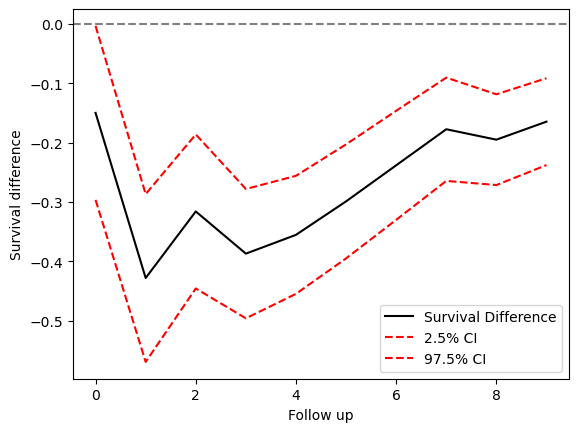

In [59]:
#call the 
predict_times = np.arange(0, 10)
trial.predict_survival_difference(predict_times)